In [1]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import xgboost as xgb
from shared_funcs import clean_time1, clean_time2, fourwks_n
import shap
from scipy import stats
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

# Predicting Daily Yield - Station 2
    We further investigate the ability to predict daily yield for each individual inverter for the next 4 days, using the previous 28 days of information.
    
    We noticed with Station 1 that minor perturbations in the data reduced the accuracy for two particular inverters that experienced a sudden drop in then recovery in yield over the span of 3 days. 
    
    The predictions made here will be done using the same criteria and method for determining the hyperparameters for Station 1.

In [2]:
df_gen2 = pd.read_csv('Plant_2_Generation_Data.csv')
df_wea2 = pd.read_csv('Plant_2_Weather_Sensor_Data.csv')

In [3]:
df_gen2 = clean_time2(df_gen2, 'DATE_TIME').drop(['DATE_TIME'],axis=1)
df_wea2 = clean_time2(df_wea2,'DATE_TIME').drop(['SOURCE_KEY','DATE_TIME'],axis=1)
result2 = pd.merge(df_gen2, df_wea2, how='outer', on=['DATE','HOUR','MINUTE']).dropna()
result2

,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,DATE,HOUR,MINUTE,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,4UPUqMRk7TRMgml,0.0,0.0,9425.000000,2.429011e+06,2020-05-15,0,0,27.004764,25.060789,0.0
1,81aHJ1q11NBPMrL,0.0,0.0,0.000000,1.215279e+09,2020-05-15,0,0,27.004764,25.060789,0.0
2,9kRcWv60rDACzjR,0.0,0.0,3075.333333,2.247720e+09,2020-05-15,0,0,27.004764,25.060789,0.0
3,Et9kgGMDl729KT4,0.0,0.0,269.933333,1.704250e+06,2020-05-15,0,0,27.004764,25.060789,0.0
4,IQ2d7wF4YD8zU1Q,0.0,0.0,3177.000000,1.994153e+07,2020-05-15,0,0,27.004764,25.060789,0.0
...,...,...,...,...,...,...,...,...,...,...,...
67693,q49J1IKaHRwDQnt,0.0,0.0,4157.000000,5.207580e+05,2020-06-17,23,45,23.202871,22.535908,0.0
67694,rrq4fwE8jgrTyWY,0.0,0.0,3931.000000,1.211314e+08,2020-06-17,23,45,23.202871,22.535908,0.0
67695,vOuJvMaM2sgwLmb,0.0,0.0,4322.000000,2.427691e+06,2020-06-17,23,45,23.202871,22.535908,0.0
67696,xMbIugepa2P7lBB,0.0,0.0,4218.000000,1.068964e+08,2020-06-17,23,45,23.202871,22.535908,0.0


In [4]:
res2_means = result2.groupby(['SOURCE_KEY','DATE'])[['AC_POWER','DC_POWER','MODULE_TEMPERATURE','AMBIENT_TEMPERATURE','IRRADIATION']].agg('mean').reset_index()
res2_max = result2.groupby(['SOURCE_KEY','DATE'])[['DAILY_YIELD']].agg('max').reset_index()
res2_information = pd.merge(res2_means,res2_max, how='outer',on=['SOURCE_KEY','DATE'])
res2_nopp = res2_information.copy()
res2_information['SOURCE_KEY'] = label_encoder.fit_transform(res2_information['SOURCE_KEY'])
res2_information


,SOURCE_KEY,DATE,AC_POWER,DC_POWER,MODULE_TEMPERATURE,AMBIENT_TEMPERATURE,IRRADIATION,DAILY_YIELD
0,0,2020-05-15,176.253459,180.133203,35.559493,30.565992,0.300622,9425.000000
1,0,2020-05-16,237.408532,242.765129,35.143314,29.478612,0.246631,5677.000000
2,0,2020-05-17,264.900233,270.686984,34.626731,29.780109,0.221183,6342.000000
3,0,2020-05-18,317.875308,325.193557,31.618089,27.336694,0.223914,7641.000000
4,0,2020-05-19,89.527148,91.363596,30.740615,26.726912,0.231197,7641.000000
...,...,...,...,...,...,...,...,...
711,21,2020-06-13,279.589350,285.872267,30.394871,26.116937,0.215523,6632.000000
712,21,2020-06-14,313.426766,320.508150,31.589834,27.019790,0.229517,7268.000000
713,21,2020-06-15,260.932183,266.637907,29.996233,26.557591,0.185053,7412.666667
714,21,2020-06-16,227.819107,232.663452,29.589896,26.369897,0.165062,6203.200000


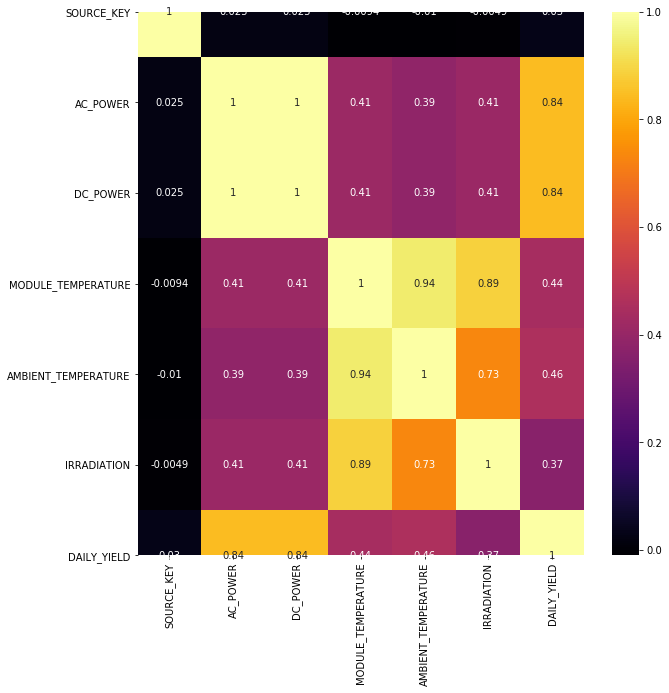

In [5]:
plt.figure(figsize=(10,10))
c = res2_information.corr(method='pearson')
sns.heatmap(c,cmap='inferno',annot=True)

Recalling from the solar_investigation notebook that the daily yield for each inverter varied wildly, we see that using the daily mean feature values presents a large drop in correlation between all features, and increase in correlation between AC and DC values and the target yield.

In [6]:
X = res2_information[['SOURCE_KEY','IRRADIATION','MODULE_TEMPERATURE','AMBIENT_TEMPERATURE','DC_POWER','AC_POWER']]
y = res2_information[['DAILY_YIELD']]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=4)

model_data, external_data = fourwks_n(res2_information,4)#splitting data into first 28days last 4 days
X_in = model_data[['SOURCE_KEY','IRRADIATION','MODULE_TEMPERATURE','AMBIENT_TEMPERATURE','DC_POWER','AC_POWER']]
y_in = model_data[['DAILY_YIELD']]
X_external = external_data[['SOURCE_KEY','IRRADIATION','MODULE_TEMPERATURE','AMBIENT_TEMPERATURE','DC_POWER','AC_POWER']]
y_external = external_data[['DAILY_YIELD']]

As with Station 1, a random selection of the data is used to determine the optimal hyperparameters through a random grid search on a 21 fold selection of data.

In [7]:
reg_xgb = xgb.XGBRegressor(n_estimators=5000,objective='reg:squarederror')
params = {
    'learning_rate': stats.uniform(0.01,0.2),
    'min_child_weight': [2,4,8,10,12,14,16,20],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'colsample_bytree': [0.5,0.6,0.7,0.8,0.9,1.0],
    'max_depth': [3,4,5,6,7,8,9,10],
    'alpha': [0.01, 0.1, 1, 10, 100]
}

In [8]:
numfolds = 21
kfolds = KFold(n_splits=numfolds, shuffle = True, random_state=4)

In [9]:
random_search = RandomizedSearchCV(reg_xgb, params, n_jobs=4, n_iter= 10,cv = kfolds.split(X,y), scoring='neg_root_mean_squared_error')
random_search.fit(X,y)
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best hyperparameters:')
print(random_search.best_params_)


 All results:
{'mean_fit_time': array([5.45788742, 2.11090958, 7.52930871, 3.33025282, 2.16528026,
       5.88312924, 3.53132341, 4.64617725, 4.99529062, 4.1977761 ]), 'std_fit_time': array([0.07544988, 0.03502876, 0.36652581, 0.08198873, 0.02937373,
       0.06754954, 0.06804791, 0.02902156, 0.02485084, 0.39451908]), 'mean_score_time': array([0.03241236, 0.01791763, 0.05370141, 0.01869264, 0.01709627,
       0.0284034 , 0.02472731, 0.02824215, 0.03484065, 0.02872935]), 'std_score_time': array([0.0046341 , 0.00056946, 0.01531455, 0.0019712 , 0.00153372,
       0.00348896, 0.00296886, 0.00099395, 0.00121908, 0.00277559]), 'param_alpha': masked_array(data=[0.1, 100, 0.1, 0.01, 100, 0.1, 1, 1, 0.1, 0.01],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_colsample_bytree': masked_array(data=[0.9, 0.5, 1.0, 0.5, 0.8, 0.9, 1.0, 1.0, 0.8, 0.9],
             mask=[False, False,

In [10]:
test_reg = xgb.XGBRegressor(alpha=0.1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.04140543133278193, max_delta_step=0, max_depth=9,
             min_child_weight=20, monotone_constraints='()',
             n_estimators=5000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0.100000001, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)
test_reg.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_test,y_test)],early_stopping_rounds=50)
print("Train RMSE: {}, Train Accuracy: {}\n Test RMSE: {}, Test Accuracy: {}".format(np.sqrt(mean_squared_error(y_train,test_reg.predict(X_train))),r2_score(y_train,test_reg.predict(X_train)),np.sqrt(mean_squared_error(y_test,test_reg.predict(X_test))),r2_score(y_test,test_reg.predict(X_test))))

[0]	validation_0-rmse:6384.39453	validation_1-rmse:6188.65137
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:6129.71143	validation_1-rmse:5944.83643
[2]	validation_0-rmse:5897.78076	validation_1-rmse:5720.54736
[3]	validation_0-rmse:5663.31689	validation_1-rmse:5498.77246
[4]	validation_0-rmse:5438.93848	validation_1-rmse:5285.05859
[5]	validation_0-rmse:5223.75049	validation_1-rmse:5082.31055
[6]	validation_0-rmse:5017.62500	validation_1-rmse:4886.56592
[7]	validation_0-rmse:4820.31982	validation_1-rmse:4699.48340
[8]	validation_0-rmse:4631.05908	validation_1-rmse:4520.92041
[9]	validation_0-rmse:4459.74512	validation_1-rmse:4356.24316
[10]	validation_0-rmse:4285.78027	validation_1-rmse:4191.53272
[11]	validation_0-rmse:4119.20654	validation_1-rmse:4033.57251
[12]	validation_0-rmse:3960.10742	validation_1-rmse:3883.84521
[13]	validation_0-rmse:3807.9692

[129]	validation_0-rmse:691.66632	validation_1-rmse:1152.78040
[130]	validation_0-rmse:690.72821	validation_1-rmse:1151.89819
[131]	validation_0-rmse:689.91425	validation_1-rmse:1151.32593
[132]	validation_0-rmse:689.20148	validation_1-rmse:1150.96948
[133]	validation_0-rmse:687.39868	validation_1-rmse:1150.05408
[134]	validation_0-rmse:685.98901	validation_1-rmse:1150.71521
[135]	validation_0-rmse:684.85577	validation_1-rmse:1150.95837
[136]	validation_0-rmse:683.78961	validation_1-rmse:1150.83032
[137]	validation_0-rmse:682.55585	validation_1-rmse:1151.12268
[138]	validation_0-rmse:681.78845	validation_1-rmse:1150.75952
[139]	validation_0-rmse:680.46747	validation_1-rmse:1150.84900
[140]	validation_0-rmse:679.65448	validation_1-rmse:1150.99512
[141]	validation_0-rmse:678.09900	validation_1-rmse:1150.14026
[142]	validation_0-rmse:677.31342	validation_1-rmse:1149.55579
[143]	validation_0-rmse:676.57941	validation_1-rmse:1148.88123
[144]	validation_0-rmse:675.40326	validation_1-rmse:114

[260]	validation_0-rmse:584.34656	validation_1-rmse:1144.91272
[261]	validation_0-rmse:583.96466	validation_1-rmse:1145.02185
[262]	validation_0-rmse:583.53723	validation_1-rmse:1145.02075
[263]	validation_0-rmse:582.16351	validation_1-rmse:1145.81458
[264]	validation_0-rmse:581.54590	validation_1-rmse:1145.73804
[265]	validation_0-rmse:580.99487	validation_1-rmse:1145.85901
[266]	validation_0-rmse:580.60742	validation_1-rmse:1146.00610
[267]	validation_0-rmse:580.06494	validation_1-rmse:1146.22961
[268]	validation_0-rmse:579.13739	validation_1-rmse:1145.80090
[269]	validation_0-rmse:578.63898	validation_1-rmse:1146.05713
[270]	validation_0-rmse:578.34582	validation_1-rmse:1145.95508
[271]	validation_0-rmse:577.36084	validation_1-rmse:1145.68164
[272]	validation_0-rmse:576.48737	validation_1-rmse:1146.17114
Stopping. Best iteration:
[222]	validation_0-rmse:609.12714	validation_1-rmse:1142.08325

Train RMSE: 609.1271560567677, Train Accuracy: 0.9141799491591147
 Test RMSE: 1142.08323405

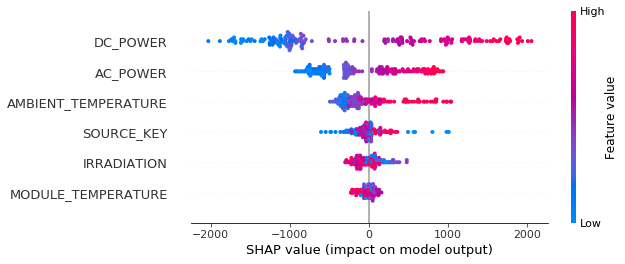

In [11]:
explainer0 = shap.TreeExplainer(test_reg)
values0 = explainer0.shap_values(X_test)

shap.summary_plot(values0,X_test)

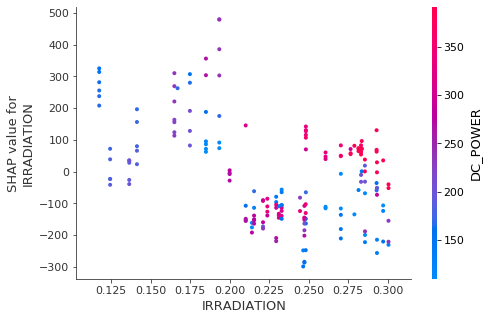

In [12]:
shap.dependence_plot('IRRADIATION', values0, X_test, interaction_index="DC_POWER")

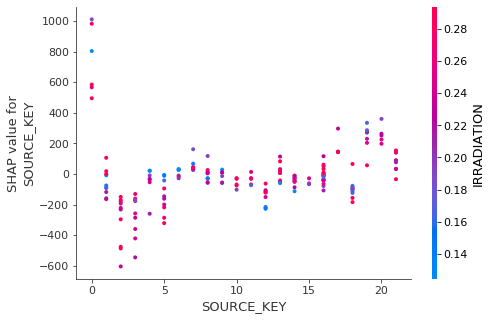

In [13]:
shap.dependence_plot('SOURCE_KEY', values0, X_test, interaction_index="IRRADIATION")

The immediate consequence of the perturbation in the data results in training and test validation scores at 91.4% and 71.9%. The 6% accuracy loss in the training data results in 28% accuracy loss in the test set.

Here we also see a greater importance put on the ambient temperature and source_key over irradiation in the model.

In [14]:
next4_reg = xgb.XGBRegressor(alpha=10, objective='reg:squarederror', base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=1.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.06891970162085885, max_delta_step=0, max_depth=5,
             min_child_weight=4, monotone_constraints='()',
             n_estimators=5000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
next4_reg.fit(X_in, y_in, eval_set=[(X_in,y_in),(X_external,y_external)],early_stopping_rounds=50)
preds = next4_reg.predict(X_external)
print("r2 Accuracy: {}".format(r2_score(y_external,preds)))

[0]	validation_0-rmse:6376.85010	validation_1-rmse:5250.70068
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:5954.84863	validation_1-rmse:4887.51123
[2]	validation_0-rmse:5562.22412	validation_1-rmse:4541.75977
[3]	validation_0-rmse:5196.97119	validation_1-rmse:4222.26953
[4]	validation_0-rmse:4857.58008	validation_1-rmse:3922.17456
[5]	validation_0-rmse:4541.85156	validation_1-rmse:3644.30640
[6]	validation_0-rmse:4248.73633	validation_1-rmse:3387.96997
[7]	validation_0-rmse:3976.01660	validation_1-rmse:3160.67407
[8]	validation_0-rmse:3722.88330	validation_1-rmse:2934.22852
[9]	validation_0-rmse:3487.49072	validation_1-rmse:2734.03687
[10]	validation_0-rmse:3269.17969	validation_1-rmse:2556.51929
[11]	validation_0-rmse:3066.46924	validation_1-rmse:2391.35522
[12]	validation_0-rmse:2877.22510	validation_1-rmse:2235.12476
[13]	validation_0-rmse:2703.0268

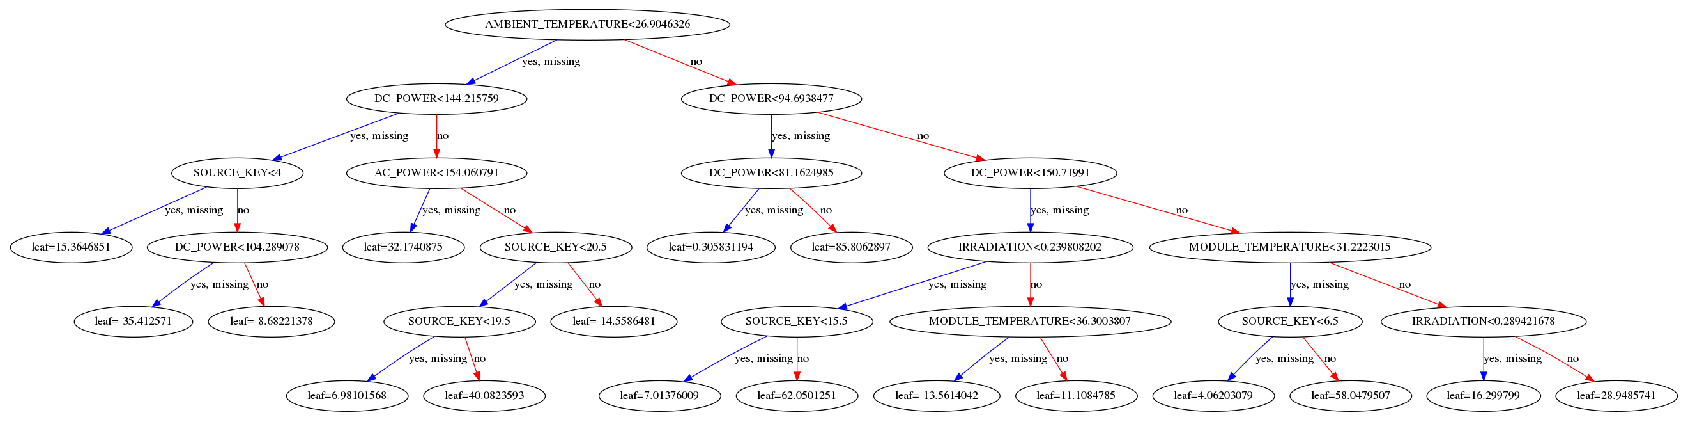

In [16]:
fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(next4_reg, num_trees=48, ax = ax)
plt.show()

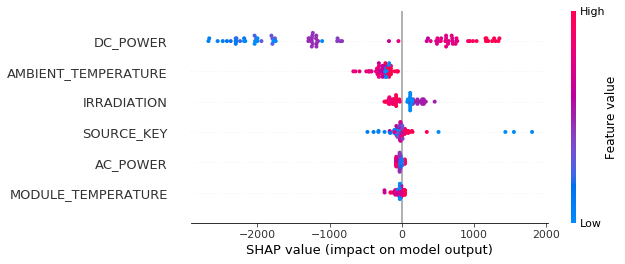

In [17]:
explainer1 = shap.TreeExplainer(next4_reg)
values1 = explainer1.shap_values(X_external)

shap.summary_plot(values1,X_external)

In [18]:
df_no , ex_nopp = fourwks_n(res2_nopp,4)
df_useful = ex_nopp.drop(['AC_POWER','DC_POWER','MODULE_TEMPERATURE','AMBIENT_TEMPERATURE','IRRADIATION'],axis=1)
df_useful.reset_index(drop=True, inplace=True)
df_predictions = pd.DataFrame({'preds':preds})
df_predictions.reset_index(drop=True, inplace=True)
df_comp = pd.concat([df_useful,df_predictions],axis=1)
df_comp

,SOURCE_KEY,DATE,DAILY_YIELD,preds
0,4UPUqMRk7TRMgml,2020-06-12,4548.000000,6636.958984
1,81aHJ1q11NBPMrL,2020-06-12,4769.000000,4590.229980
2,9kRcWv60rDACzjR,2020-06-12,4693.000000,4610.511230
3,Et9kgGMDl729KT4,2020-06-12,3743.000000,3886.860352
4,IQ2d7wF4YD8zU1Q,2020-06-12,4802.000000,4953.022461
...,...,...,...,...
83,q49J1IKaHRwDQnt,2020-06-15,7476.000000,6822.044434
84,rrq4fwE8jgrTyWY,2020-06-15,7271.000000,4509.952637
85,vOuJvMaM2sgwLmb,2020-06-15,7463.000000,6864.848633
86,xMbIugepa2P7lBB,2020-06-15,7340.000000,6970.222656


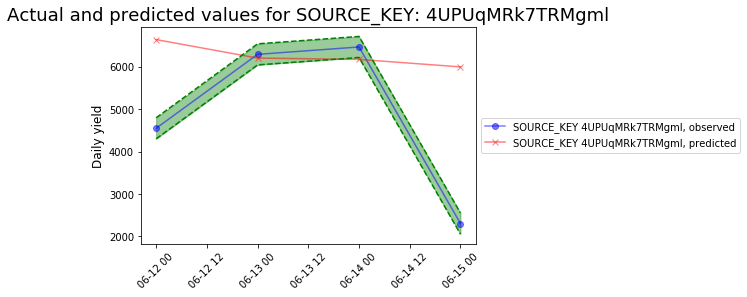

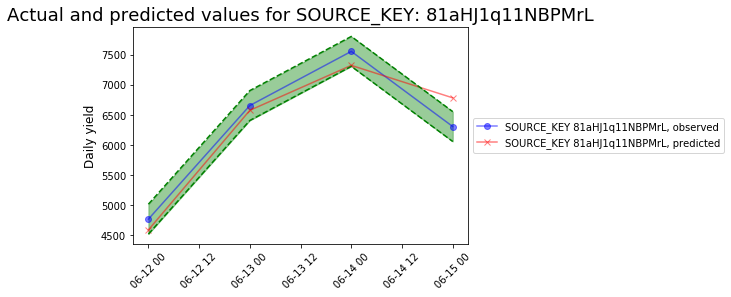

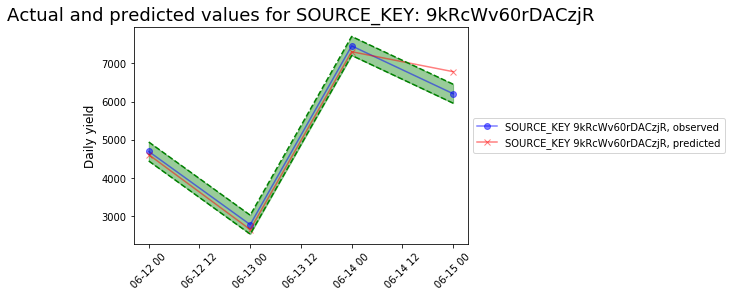

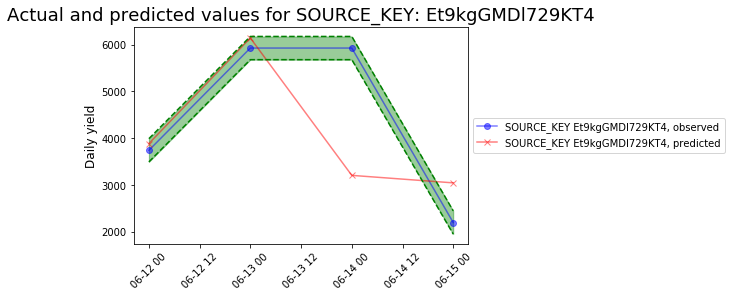

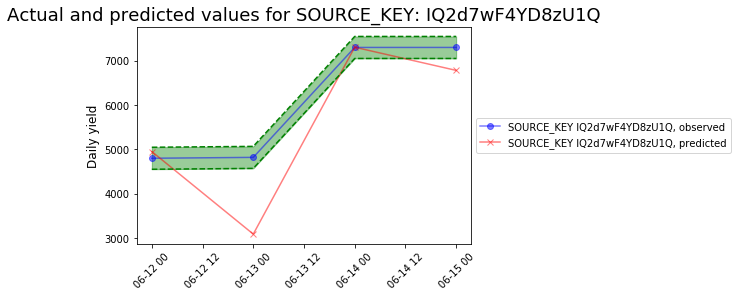

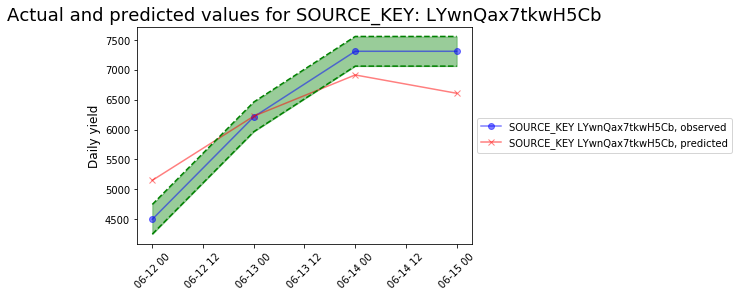

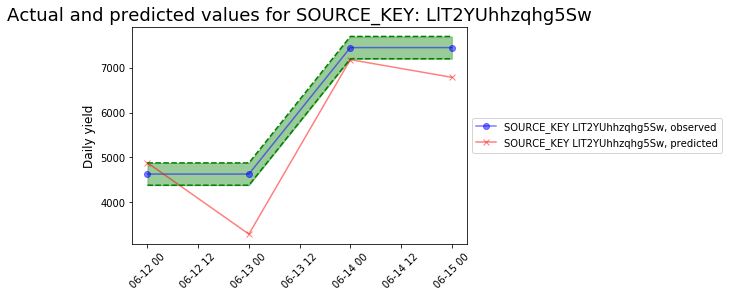

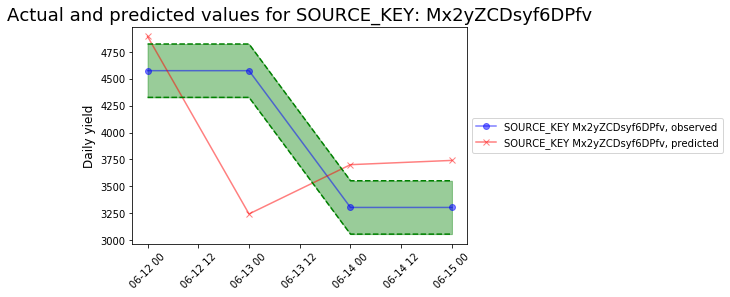

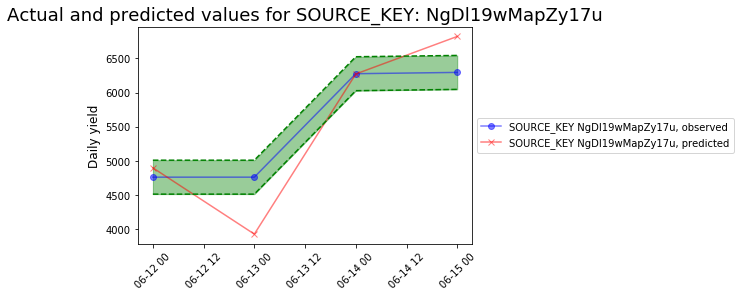

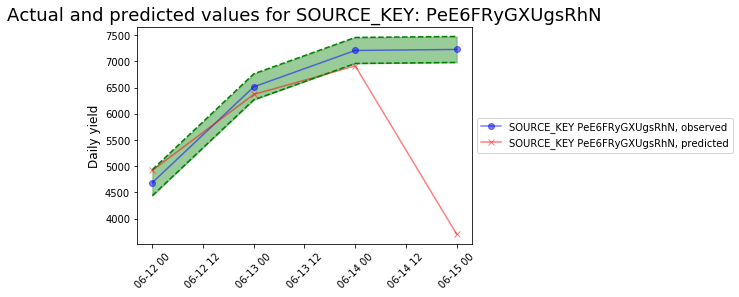

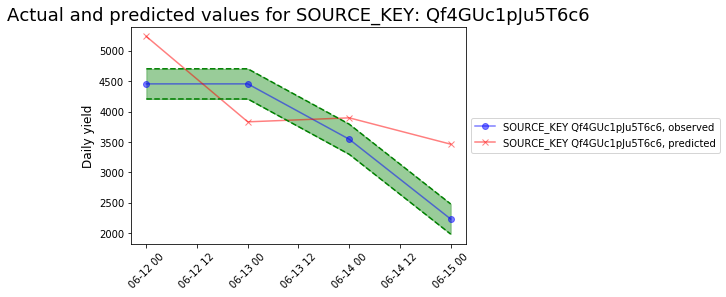

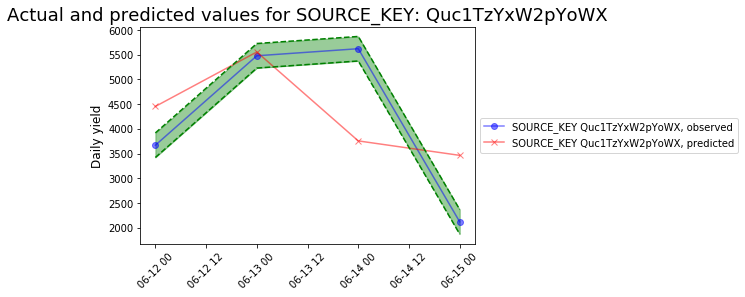

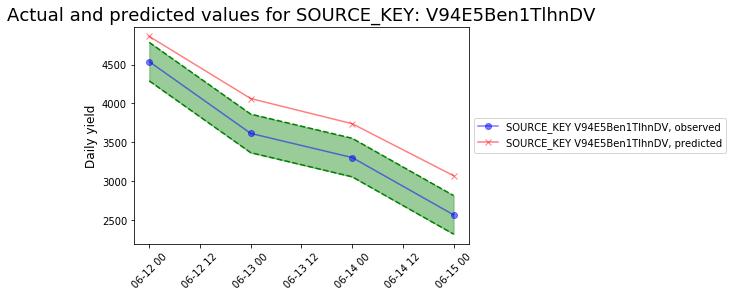

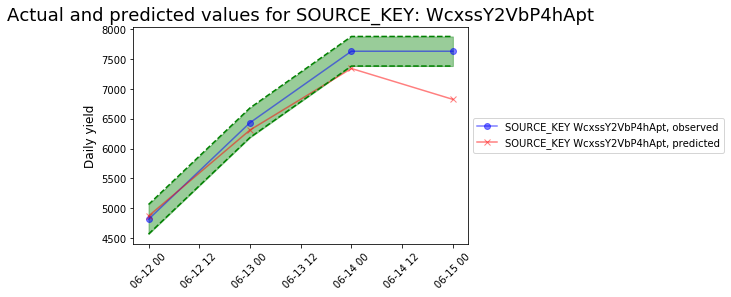

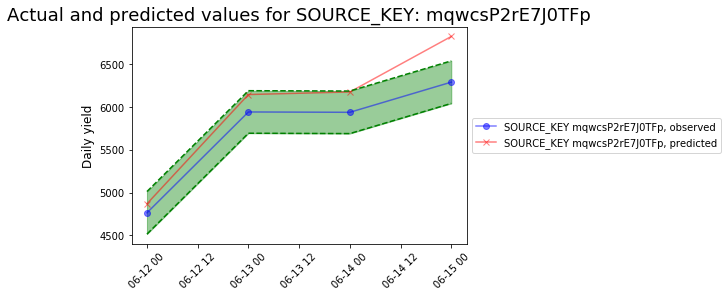

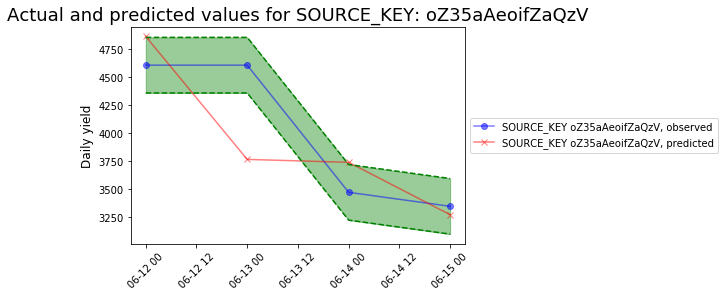

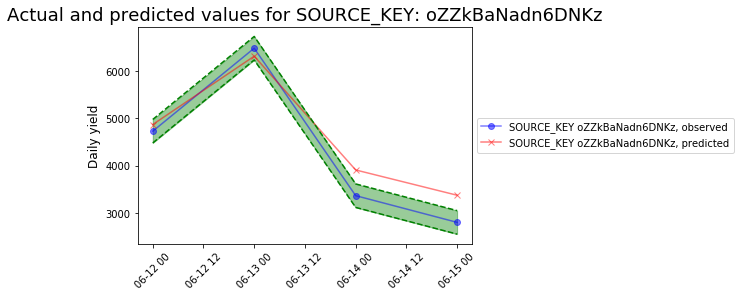

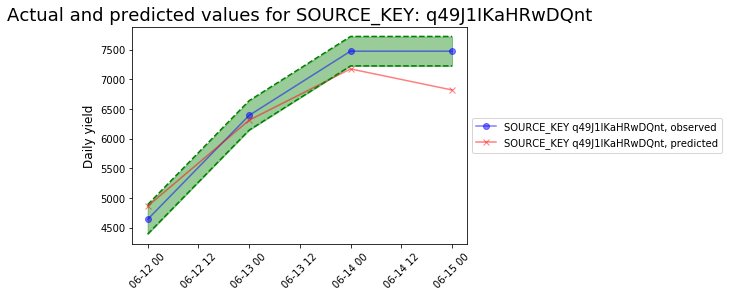

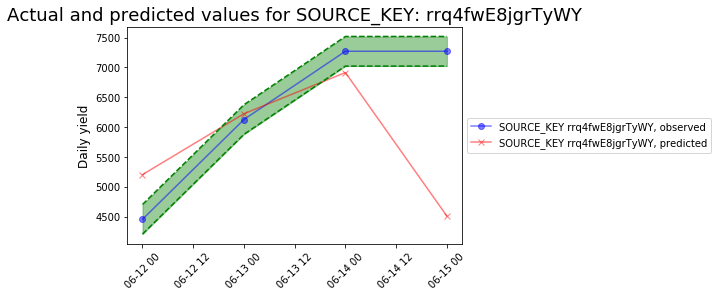

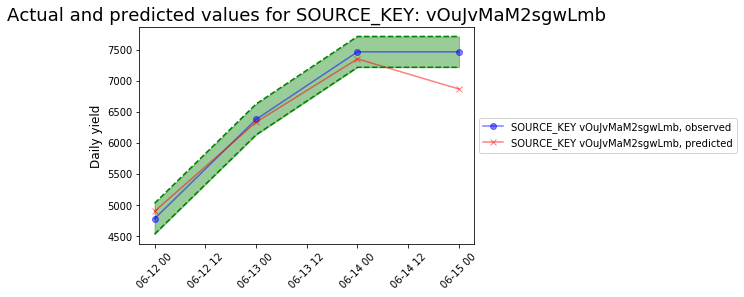

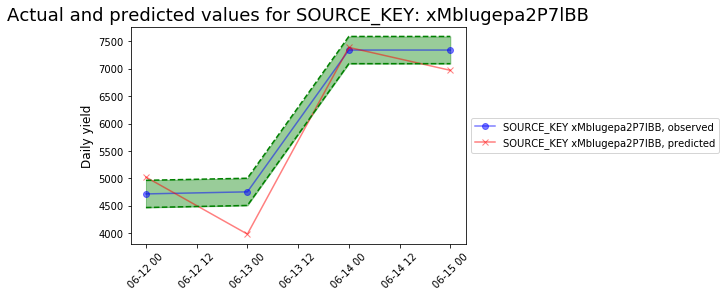

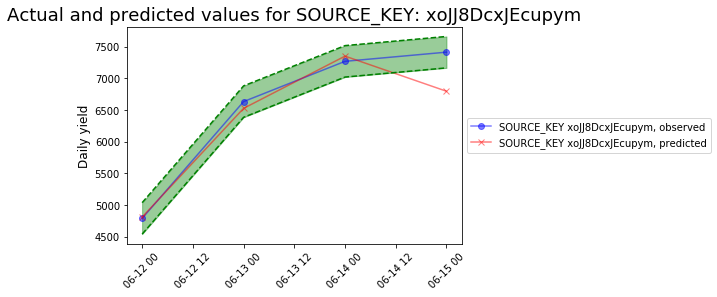

In [19]:
key_list= df_comp.SOURCE_KEY.unique()

for key in key_list:
    df = df_comp[df_comp['SOURCE_KEY']==key]
    plt.plot(df.DATE,df.DAILY_YIELD,label='SOURCE_KEY {}, observed'.format(key),color='blue',alpha=.5,marker='o')
    plt.plot(df.DATE,df.preds, label='SOURCE_KEY {}, predicted'.format(key),color='red',alpha=.5,marker='x')
    plt.plot(df.DATE,df.DAILY_YIELD+248.16400, linestyle='dashed',color='green')
    plt.plot(df.DATE,df.DAILY_YIELD-248.16400, linestyle='dashed',color='green')
    plt.fill_between(df.DATE,df.DAILY_YIELD+248.16400,df.DAILY_YIELD-248.16400,color='green',alpha=.4)
    plt.legend(loc = 'center left', bbox_to_anchor =(1,0.5))
    plt.title('Actual and predicted values for SOURCE_KEY: {}'.format(key), fontsize=18)
    plt.ylabel('Daily yield', fontsize=12)
    plt.xticks(rotation=45)
    plt.show()

# Conclusion
    Comparing the results for prediction yield at Station 2 with Station 1 suggests that the ability to predict the next several days of yield is heavily impacted by perturbation of the data. The smooth values observed are rife with over and under predicted values due to high variance between days throughout the recording period.
    
    Thus with better management and observation of grid performance, it would be possible to identify issues with energy production to allow for better predictions.